<a href="https://colab.research.google.com/github/geoifg/SMS/blob/main/Script_Boosting_classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -----------------------------------------------
# Autor: Édipo H. Cremon
# Data: 2025-05-13
# Versão Python: compatível com Google Colab
# -----------------------------------------------

# Instale bibliotecas se necessário
!pip install xgboost

# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [2]:
# Carregar dados
url = "https://raw.githubusercontent.com/geoifg/SMS/main/titanic.csv"
df = pd.read_csv(url, sep=";", decimal=".")


In [3]:
# Conversões
df['Survived'] = df['Survived'].map({1: 'Yes', 0: 'No'}).astype('category')
df['Embarked'] = df['Embarked'].map({'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'})
df.drop(columns=['PassengerId', 'Name', 'Cabin', 'Ticket'], inplace=True)

In [4]:
# Tipos categóricos
cat_cols = ['Pclass', 'Sex', 'Embarked']
for col in cat_cols:
    df[col] = df[col].astype('category')

In [5]:
# Imputação
df['Age'] = df['Age'].fillna(df['Age'].median())
df.dropna(subset=['Fare'], inplace=True)

In [6]:
# One-hot encoding
X = pd.get_dummies(df.drop(columns=['Survived']), drop_first=True)
y = df['Survived']

In [7]:
# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=100)


In [9]:
# ----------------------------
# 1. CART (Decision Tree)
# ----------------------------
cart = GridSearchCV(
    DecisionTreeClassifier(random_state=100),
    param_grid={'max_depth': [3, 5, 7, 10]},
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=100),
    scoring='roc_auc',
    n_jobs=-1
)
cart.fit(X_train, y_train)
y_pred_cart = cart.predict(X_test)
y_prob_cart = cart.predict_proba(X_test)[:, 1]
print("CART - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cart))
print("CART - AUC:", roc_auc_score((y_test == 'Yes').astype(int), y_prob_cart))

CART - Confusion Matrix:
 [[154  11]
 [ 34  69]]
CART - AUC: 0.8415122094733745


In [10]:
# ----------------------------
# 2. Regressão Logística
# ----------------------------
logit = GridSearchCV(
    LogisticRegression(solver='liblinear', random_state=100),
    param_grid={'C': [0.01, 0.1, 1, 10]},
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=100),
    scoring='roc_auc',
    n_jobs=-1
)
logit.fit(X_train, y_train)
y_pred_log = logit.predict(X_test)
y_prob_log = logit.predict_proba(X_test)[:, 1]
print("Logistic Regression - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Logistic Regression - AUC:", roc_auc_score((y_test == 'Yes').astype(int), y_prob_log))

Logistic Regression - Confusion Matrix:
 [[143  22]
 [ 27  76]]
Logistic Regression - AUC: 0.8785819358634893


In [11]:
# ----------------------------
# 3. Random Forest
# ----------------------------
rf = GridSearchCV(
    RandomForestClassifier(random_state=100),
    param_grid={'n_estimators': [100], 'max_depth': [5, 10]},
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=100),
    scoring='roc_auc',
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
print("Random Forest - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Random Forest - AUC:", roc_auc_score((y_test == 'Yes').astype(int), y_prob_rf))


Random Forest - Confusion Matrix:
 [[152  13]
 [ 30  73]]
Random Forest - AUC: 0.8943218593704031


In [12]:
# ----------------------------
# 4. Gradient Boosting (GBM)
# ----------------------------
gbm = GridSearchCV(
    GradientBoostingClassifier(random_state=100),
    param_grid={'n_estimators': [100], 'learning_rate': [0.05, 0.1]},
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=100),
    scoring='roc_auc',
    n_jobs=-1
)
gbm.fit(X_train, y_train)
y_pred_gbm = gbm.predict(X_test)
y_prob_gbm = gbm.predict_proba(X_test)[:, 1]
print("GBM - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gbm))
print("GBM - AUC:", roc_auc_score((y_test == 'Yes').astype(int), y_prob_gbm))


GBM - Confusion Matrix:
 [[147  18]
 [ 26  77]]
GBM - AUC: 0.8914974992644896


In [15]:
# Codificar classes como 0/1 para o XGBoost
y_train_bin = (y_train == 'Yes').astype(int)
y_test_bin = (y_test == 'Yes').astype(int)

xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=100),
    param_grid={'n_estimators': [100], 'learning_rate': [0.05, 0.1]},
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=100),
    scoring='roc_auc',
    n_jobs=-1
)
xgb.fit(X_train, y_train_bin)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]
print("XGBoost - Confusion Matrix:\n", confusion_matrix(y_test_bin, y_pred_xgb))
print("XGBoost - AUC:", roc_auc_score(y_test_bin, y_prob_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:24:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Confusion Matrix:
 [[150  15]
 [ 28  75]]
XGBoost - AUC: 0.8793468667255075


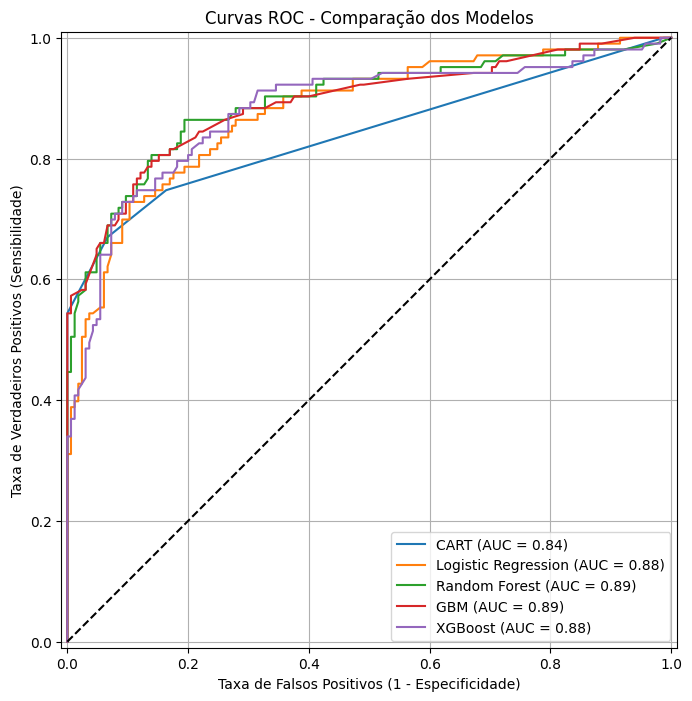

In [17]:
# ----------------------------
# Comparação das curvas ROC
# ----------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Abrir a figura
plt.figure(figsize=(10, 8))

# Plotar curva ROC de cada modelo
RocCurveDisplay.from_predictions((y_test == 'Yes').astype(int), y_prob_cart, name='CART', ax=plt.gca())
RocCurveDisplay.from_predictions((y_test == 'Yes').astype(int), y_prob_log, name='Logistic Regression', ax=plt.gca())
RocCurveDisplay.from_predictions((y_test == 'Yes').astype(int), y_prob_rf, name='Random Forest', ax=plt.gca())
RocCurveDisplay.from_predictions((y_test == 'Yes').astype(int), y_prob_gbm, name='GBM', ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_bin, y_prob_xgb, name='XGBoost', ax=plt.gca())

# Personalização do gráfico
plt.plot([0, 1], [0, 1], 'k--')  # linha de referência
plt.title('Curvas ROC - Comparação dos Modelos')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
plt.grid(True)
plt.legend()
plt.show()
